In [2]:
# ライブラリ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import torch
import torchvision
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import init


from functools import partial
from PIL import Image
import cv2
import os

import shutil
import time

from torchvision import models
from torchvision.models.vgg import VGG13_Weights

In [1]:
def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None, scheduler=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve = 0

    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        for data in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=True):
            X, y = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            preds = model(X)
            loss = loss_func(preds, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        running_val_loss = 0.0
        running_val_acc = 0.0
        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=True):
                X_val, y_val = data[0].to(device), data[1].to(device)
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = (preds_val.argmax(dim=-1) == y_val).float().mean()
                running_val_acc += val_accuracy.item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = running_val_acc / len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
        else:
            no_improve += 1

        if early_stopping and no_improve >= early_stopping:
            print('Stopping early due to no improvement')
            break

        if scheduler:
            scheduler.step()

    return train_losses, val_losses, val_accuracies


In [3]:
# モデルをテストする

transform_test = transforms.Compose([
    # テストデータのサイズを変える
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# モデルをテストしてみる

def test_image(image_path):
    image = Image.open(image_path).convert('RGB')  # RGB形式で画像を開く
    image = transform_test(image)  # 定義した前処理を適用
    image = image.unsqueeze(0).to(device)  # バッチの次元を追加
    return image



def test_all_images(directory, model):
    results = []
    correct = 0
    total = 0
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            # 正解ラベルの抽出
            true_label = 'Dog' if 'dog' in filename.lower() else 'Cat'

            file_path = os.path.join(directory, filename)
            image = test_image(file_path)

            with torch.no_grad():
                output = model(image)
                _, predicted = torch.max(output, 1)
                predicted_label = 'Dog' if predicted.item() == 0 else 'Cat'

                # 結果の保存と正解判定
                results.append((filename, predicted_label))
                if predicted_label == true_label:
                    correct += 1
                total += 1

    accuracy = correct / total * 100 if total > 0 else 0
    return results, correct, total, accuracy



In [4]:
# cpuかGPUか確認する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [5]:

class ActivationStatistics:

    def __init__(self, model):
        self.model = model
        self.act_means = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))

    def save_out_stats(self, i, module, inp, out):
        # relu層からout(mean, std)は計算グラフを作成するので、計算グラフを作成しない処理 -> detach
        # detachをするとCPUで学習するので、明示的にCPUで処理するようにする。
        self.act_means[i].append(out.detach().cpu().mean().item())
        self.act_stds[i].append(out.detach().cpu().std().item())

    def get_statstics(self):
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title('Activation means')
        plt.legend(range(len(self.act_means)))


        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title('Activation means')
        plt.legend(range(len(self.act_stds)))

        plt.show()

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class DogCatClassificationModel(nn.Module):
    def __init__(self, in_ch):
        super(DogCatClassificationModel, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.adaptive = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, 64)
        self.dropout1 = nn.Dropout(0.4)  # ドロップアウト追加
        self.fc2 = nn.Linear(64, 2)
        # 重みの初期化メソッドを呼び出し
        self._initialize_weights()

    def forward(self, X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.relu(self.bn2(self.conv2(X)))
        X = F.relu(self.bn3(self.conv3(X)))
        X = F.relu(self.bn4(self.conv4(X)))
        X = self.adaptive(X)
        X = self.flatten(X)
        X = self.dropout1(F.relu(self.fc1(X)))  # ドロップアウトを活性化層の後に適用
        X = self.fc2(X)
        return X

    def _initialize_weights(self):
        # 各モジュールに対してループを行う
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # He初期化を適用
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    # バイアスを0で初期化
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                # BatchNormの重みを1で初期化
                init.constant_(m.weight, 1)
                # バイアスを0で初期化
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # 全結合層の重みをHe初期化
                init.kaiming_normal_(m.weight)
                # バイアスを0で初期化
                init.constant_(m.bias, 0)

# # モデルインスタンスの作成
# model = DogCatClassificationModel(3)
# model.to(device)  # モデルを適切なデバイスに移動

# 学習させてみる



## データを確認する

In [6]:
# 画像のファイルパス
dog_path = '/work/data/Dog/'
cat_path = '/work/data/Cat/'


# 画像ディレクトリ内のファイル一覧を取得
dog_image_files = os.listdir(dog_path)
cat_image_files = os.listdir(cat_path)

# 最初の画像だけを処理する
image_dog_path = os.path.join(dog_path, dog_image_files[1])
image_cat_path = os.path.join(cat_path, cat_image_files[0])

dog_image = Image.open(image_dog_path)
cat_image = Image.open(image_cat_path)

# 画像の形状を出力する
print('dog image shape : ', dog_image.size)
print('cat image shape : ', cat_image.size)

dog image shape :  (401, 500)
cat image shape :  (365, 500)


In [7]:
# 画像を表示
print(type(cat_image))
print(type(dog_image))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>


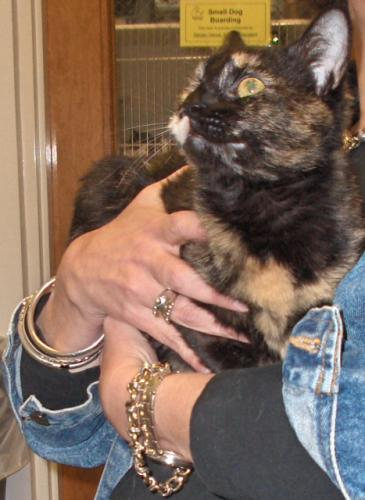

In [8]:
cat_image

## 一回学習してみる

### dataset, dataloader

In [9]:
# ファイルの確認
print("dog files:", len(os.listdir(dog_path)))
print("cat files:", len(os.listdir(cat_path)))


dog files: 12501
cat files: 12501


In [10]:
# # dogファイルとcatファイルにtrain, valディレクトリを作成する

# dog_train_dir = '/work/data/Dog/train'
# cat_train_dir = '/work/data/Cat/train'

# dog_val_dir = '/work/data/Dog/val'
# cat_val_dir = '/work/data/Cat/val'

# # トレーニングと検証ディレクトリを作成する
# os.makedirs(dog_train_dir, exist_ok=True)
# os.makedirs(dog_val_dir, exist_ok=True)
# os.makedirs(cat_train_dir, exist_ok=True)
# os.makedirs(cat_val_dir, exist_ok=True)

# # 全画像取得
# dog_files = [os.path.join(dog_path, f) for f in os.listdir(dog_path) if f.endswith('.jpg')]
# cat_files = [os.path.join(cat_path, f) for f in os.listdir(cat_path) if f.endswith('jpg')]

# # ファイルをシャッフルし、80%をtraining, 20%をvalに分割
# np.random.shuffle(dog_files)
# np.random.shuffle(cat_files)

# dog_split_point = int(0.8 * len(dog_files))
# cat_split_point = int(0.8 * len(cat_files))

# dog_train_files = dog_files[:dog_split_point]
# cat_train_files = dog_files[:cat_split_point]
# dog_val_files = cat_files[dog_split_point:]
# cat_val_files = cat_files[cat_split_point:]

# # 各ファイルを対応するディレクトリに移動
# for f in dog_train_files:
#     shutil.move(f, dog_train_dir)

# for f in cat_train_files:
#     shutil.move(f, cat_train_dir)

# for f in dog_val_files:
#     shutil.move(f, dog_val_dir)

# for f in cat_val_files:
#     shutil.move(f, cat_val_dir)
    



FileNotFoundError: [Errno 2] No such file or directory: '/work/data/Dog/8429.jpg'

In [ ]:
# import os

# def count_images(directory, extension='.jpg'):
#     """指定されたディレクトリ内の特定の拡張子を持つファイルの数をカウントします。"""
#     # ディレクトリ内のファイルをリストアップ
#     files = os.listdir(directory)
#     # 指定された拡張子を持つファイルの数をカウント
#     count = sum(1 for f in files if f.endswith(extension))
#     return count

# # ディレクトリパスを指定
# dog_train_dir = '/work/data/Dog/train'
# cat_train_dir = '/work/data/Cat/train'

# dog_val_dir = '/work/data/Dog/val'
# cat_val_dir = '/work/data/Cat/val'

# # JPGファイルの数をカウント
# dog_train_jpg_count = count_images(dog_train_dir, '.jpg')
# dog_val_jpg_count = count_images(cat_train_dir, '.jpg')
# cat_train_jpg_count = count_images(dog_train_dir, '.jpg')
# cat_val_jpg_count = count_images(cat_train_dir, '.jpg')
# # full_dog_jpg_count = count_images('/work/data/Dog/', '.jpg')


# print(f"There are {dog_train_jpg_count} JPEG files in {dog_train_dir}")
# print(f"There are {dog_val_jpg_count} JPEG files in {dog_val_dir}")
# print(f"There are {cat_train_jpg_count} JPEG files in {cat_train_dir}")
# print(f"There are {cat_val_jpg_count} JPEG files in {cat_val_dir}")

# # print(full_dog_jpg_count)


In [ ]:
# import os
# import shutil
# import numpy as np

# # ディレクトリパスを指定
# dog_train_dir = '/work/data/Dog/train'
# dog_val_dir = '/work/data/Dog/val'
# cat_train_dir = '/work/data/Cat/train'
# cat_val_dir = '/work/data/Cat/val'

# # trainディレクトリから全画像を取得
# dog_train_files = [os.path.join(dog_train_dir, f) for f in os.listdir(dog_train_dir) if f.endswith('.jpg')]
# cat_train_files = [os.path.join(cat_train_dir, f) for f in os.listdir(cat_train_dir) if f.endswith('.jpg')]

# # ファイルをシャッフル
# np.random.shuffle(dog_train_files)
# np.random.shuffle(cat_train_files)

# # 20%をvalidationに移動
# dog_val_count = int(0.2 * len(dog_train_files))
# cat_val_count = int(0.2 * len(cat_train_files))

# dog_val_files = dog_train_files[:dog_val_count]
# cat_val_files = cat_train_files[:cat_val_count]

# # 残りのファイルはtrainにそのまま
# dog_train_files = dog_train_files[dog_val_count:]
# cat_train_files = cat_train_files[cat_val_count:]

# # valファイルをvalディレクトリに移動
# for f in dog_val_files:
#     shutil.move(f, dog_val_dir)

# for f in cat_val_files:
#     shutil.move(f, cat_val_dir)

# print("dog Training files:", len(os.listdir(dog_train_dir)))
# print("cat Training files:", len(os.listdir(cat_train_dir)))
# print("dog Validation files:", len(os.listdir(dog_val_dir)))
# print("cat Validation files:", len(os.listdir(cat_val_dir)))
# print('cat data', len(os.listdir('/work/data/Cat')))

In [ ]:
# # dogとcat dataをtrainとvalに分ける (完成版)
# import os
# import shutil
# import numpy as np

# # 正しいパスを設定
# dog_path = '/work/data/Dog'
# cat_path = '/work/data/Cat'

# dog_train_dir = '/work/data/Dog/train'
# cat_train_dir = '/work/data/Cat/train'
# dog_val_dir = '/work/data/Dog/val'
# cat_val_dir = '/work/data/Cat/val'

# # ディレクトリが存在しなければ作成
# os.makedirs(dog_train_dir, exist_ok=True)
# os.makedirs(dog_val_dir, exist_ok=True)
# os.makedirs(cat_train_dir, exist_ok=True)
# os.makedirs(cat_val_dir, exist_ok=True)

# # 全画像取得
# dog_files = [os.path.join(dog_path, f) for f in os.listdir(dog_path) if f.endswith('.jpg')]
# cat_files = [os.path.join(cat_path, f) for f in os.listdir(cat_path) if f.endswith('.jpg')]

# # ファイルをシャッフル
# np.random.shuffle(dog_files)
# np.random.shuffle(cat_files)

# # 20%をvalidationに移動
# dog_val_count = int(0.2 * len(dog_files))
# cat_val_count = int(0.2 * len(cat_files))

# dog_val_files = dog_files[:dog_val_count]
# cat_val_files = cat_files[:cat_val_count]

# # 残りのファイルはtrainに
# dog_train_files = dog_files[dog_val_count:]
# cat_train_files = cat_files[cat_val_count:]

# # 各ファイルを対応するディレクトリに移動
# for f in dog_train_files:
#     shutil.move(f, dog_train_dir)

# for f in cat_train_files:
#     shutil.move(f, cat_train_dir)

# for f in dog_val_files:
#     shutil.move(f, dog_val_dir)

# for f in cat_val_files:
#     shutil.move(f, cat_val_dir)

# print("dog Training files:", len(os.listdir(dog_train_dir)))
# print("cat Training files:", len(os.listdir(cat_train_dir)))
# print("dog Validation files:", len(os.listdir(dog_val_dir)))
# print("cat Validation files:", len(os.listdir(cat_val_dir)))


In [ ]:
# # transform
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5))
# ])

# # データセット
# dog_train_dataset = datasets.ImageFolder(root='/work/data/Dog/train', transform=transform)
# dog_val_dataset = datasets.ImageFolder(root='/work/data/Dog/val', transform=transform)
# cat_train_dataset = datasets.ImageFolder(root='/work/data/Cat/train', transform=transform)
# cat_val_dataset = datasets.ImageFolder(root='/work/data/Cat/val', transform=transform)

# # データローダー
# dog_train_loader = DataLoader(dog_train_dataset, batch_size=32, shuffle=True)
# dog_val_loader = DataLoader(dog_val_dataset, batch_size=32, shuffle=False)
# cat_train_loader = DataLoader(cat_train_dataset, batch_size=32, shuffle=True)
# cat_val_loader = DataLoader(cat_val_dataset, batch_size=32, shuffle=False)


## ここから

In [10]:
data_folder = '/work/data/'
transform_dict = {
    'train':transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5))
]),
    'test' : transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5))
])
}

dataset = torchvision.datasets.ImageFolder(root=data_folder, transform=transform_dict['train'])

# trainとvalに分割(8:2)
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# データローダの作成
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)


In [11]:
# model作成
model = models.vgg13(weights=VGG13_Weights.IMAGENET1K_V1)

In [ ]:
# optimizer 
opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_func = F.cross_entropy
num_epoch = 10
train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, loss_func, num_epoch)

Epoch 1 Training:   0%|          | 0/313 [00:00<?, ?it/s]